In [1]:
import Functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

In [2]:

# Generate grid of traders
def grid_stock_market(L, fundamentalist_probability):
    # Generate an L by L array with random values between 0 and 1
    random_grid = np.random.rand(L, L)
    # Convert values to 0 or 1 based on the probability of a fundamentalist
    result_grid = (random_grid > fundamentalist_probability).astype(int)
    return result_grid

# Required for all levels
# Set up transition table
def transition_table(array):
    return np.mean(np.array(array))

# Transaction quantity
def calculation_transaction_quantity(transactions, L):
    total_transactions = 0
    for row in range(L):
        for column in range(L):
            total_transactions = total_transactions + transactions[row, column]
    return total_transactions

# Price function 
def price_function(previous_price, sensitivity_contant, L, transaction_quantity):
    price = previous_price + sensitivity_contant*transaction_quantity/(L**2)
    if price < 0 :
        price = 0
    return price

# Set up function for state changes (Level 1)
def next_state(trader_grid, cur_state, price, fundamental_value, L):
    
    transaction_quantity = np.zeros(np.shape(cur_state))
    assert (L, L) == np.shape(cur_state)
    
    for row_index in range(L):
        for column_index in range(L):
            trader_type = trader_grid[row_index, column_index]
            if trader_type == 0:
                transaction_quantity[row_index,column_index] = fundamental_value - price
            else: 
                transaction_quantity[row_index,column_index] = transition_table([cur_state[(row_index-1)%L, column_index%L], cur_state[(row_index+1)%L, column_index%L], cur_state[(row_index)%L, (column_index-1)%L], cur_state[(row_index)%L, (column_index+1)%L], cur_state[(row_index-1)%L, (column_index-1)%L], cur_state[(row_index-1)%L, (column_index+1)%L], cur_state[(row_index+1)%L, (column_index-1)%L],cur_state[(row_index+1)%L, (column_index+1)%L]])
    
    return transaction_quantity

# Expansion for function of level 2
def news_influence(parameters):
    c_fundamentalist, c_imitator = parameters
    factor_news_fundamentalist = 1 + c_fundamentalist*np.random.normal(loc = 0.0, scale = 1.0)
     
    factor_news_imitator = 1 + c_imitator*np.random.normal(loc = 0.0, scale = 1.0)
    factor_news = [factor_news_fundamentalist, factor_news_imitator]
    return np.array(factor_news)

def next_state_Level_2(trader_grid, cur_state, price_list, fundamental_value, news_relevance, L):
    
    transaction_quantity = np.zeros(np.shape(cur_state))
    assert (L, L) == np.shape(cur_state)
    news_both = news_influence(news_relevance)
    for row_index in range(L):
        for column_index in range(L):
            trader_type = trader_grid[row_index, column_index]
            
            if trader_type == 0:
                price = price_list[-1]
                news = news_both[0]
                transaction_quantity[row_index,column_index] = (fundamental_value*news - price)
            else: 
                news = news_both[1]
                transaction_quantity[row_index,column_index] = news*transition_table([cur_state[(row_index-1)%L, column_index%L], cur_state[(row_index+1)%L, column_index%L], cur_state[(row_index)%L, (column_index-1)%L], cur_state[(row_index)%L, (column_index+1)%L], cur_state[(row_index-1)%L, (column_index-1)%L], cur_state[(row_index-1)%L, (column_index+1)%L], cur_state[(row_index+1)%L, (column_index-1)%L],cur_state[(row_index+1)%L, (column_index+1)%L]])
    
    return transaction_quantity

# Expansion for level 3
def price_fluctuations(k, prices):
    k = min(k, len(prices))
    P_bar = sum(prices[-k:]) / k  # Calculate the average price
    Lt = sum(abs(P_i - P_bar) for P_i in prices[-k:]) / (k*P_bar)
    return Lt


def trading_activity_function(Cl, Lt, Lm):
    """
    Calculate the current trading activity M^t.

    :param Lt: Current price volatility level
    :param Cl: Parameter
    :param Lm: Threshold
    :return: Current trading activity level
    """
    # The lower bound of Mt is 0.05
    # return 1.1
    if Lt <= Lm:
        return max(Cl * Lt, 0.05)
    else:
        return max(Cl * (-Lt + 2 * Lm), 0.05)
    
def next_state_Level_3(trader_grid, cur_state, price_list, fundamental_value, news_relevance, L, trades):
    
    transaction_quantity = np.zeros(np.shape(cur_state))
    assert (L, L) == np.shape(cur_state)
    
    news_both = news_influence(news_relevance)
    for row_index in range(L):
        for column_index in range(L):
            trader_type = trader_grid[row_index, column_index]
            
            if trader_type == 0:
                price = price_list[-1]
                news = news_both[0]
                transaction_quantity[row_index,column_index] = (fundamental_value*news - price) * trades
            else:
                news = news_both[1]
                transaction_quantity[row_index,column_index] = trades*news*transition_table([cur_state[(row_index-1)%L, column_index%L], cur_state[(row_index+1)%L, column_index%L], cur_state[(row_index)%L, (column_index-1)%L], cur_state[(row_index)%L, (column_index+1)%L], cur_state[(row_index-1)%L, (column_index-1)%L], cur_state[(row_index-1)%L, (column_index+1)%L], cur_state[(row_index+1)%L, (column_index-1)%L],cur_state[(row_index+1)%L, (column_index+1)%L]])
    
    return transaction_quantity


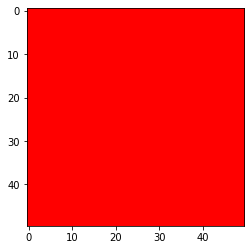

In [14]:
def Level_1_simulation(trader_grid, initial_price, fundamental_value, time, L, sensitivity_contant):
    # initialize price list for market
    price_list = [initial_price]
    # initialize transaction quantities. Note that this implies at t=0 we initialize with imitators not trading and fundamentalists changing to the updated price values
    transaction_quantities = Functions.next_state(trader_grid, np.zeros((L,L)), price_list[-1], fundamental_value, L)
    transactions = [transaction_quantities]
    for t in range(time):
        transactions.append(Functions.next_state(trader_grid, transactions[-1], price_list[-1], fundamental_value, L))
        trans_quantity = Functions.calculation_transaction_quantity(transactions[-1], L)
        price_list.append(Functions.price_function(price_list[-1],sensitivity_contant,L, trans_quantity))
    return np.array(transactions), np.array(price_list)

# Initialize the grid with a certain probability of fundamentalists
L = 50
fundamentalists_probability = 0.8
trader_grid = grid_stock_market(L, fundamentalists_probability)

# Set the parameters for the simulation
initial_price = 105
fundamental_value = 100
time = 100
sensitivity_constant = 0.5

# Create a color map for fundamentalists and imitators
cmap = ListedColormap(['#FF0000', '#0000FF'])  # Red for fundamentalists, Blue for imitators

# Prepare the figure for animation
fig, ax = plt.subplots()
im = ax.imshow(trader_grid, cmap=cmap, interpolation='nearest')

# Initialize the simulation with the initial state of the grid
transactions, price_list = Level_1_simulation(trader_grid, initial_price, fundamental_value, time, L, sensitivity_constant)

# Animation update function
def update(frame):
    global trader_grid, transactions, price_list
    if frame == 0:
        return [im]  # Skip the first frame, as we already have the initial state
    
    # Only update the trader grid and price list if we are at a new frame
    if frame >= len(price_list):
        # Run the simulation step
        new_transactions, new_prices = Level_1_simulation(trader_grid, price_list[-1], fundamental_value, 1, L, sensitivity_constant)
        transactions = np.append(transactions, new_transactions, axis=0)
        price_list = np.append(price_list, new_prices)

    # Update the image object with the new grid state, reflecting trader types
    im.set_data(transactions[frame])
    return [im]

# Create the animation object
ani = FuncAnimation(fig, update, frames=time, blit=True)

# Save the animation to a file (this will require ffmpeg to be installed on your system)
ani.save('stock_market_simulation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.show()

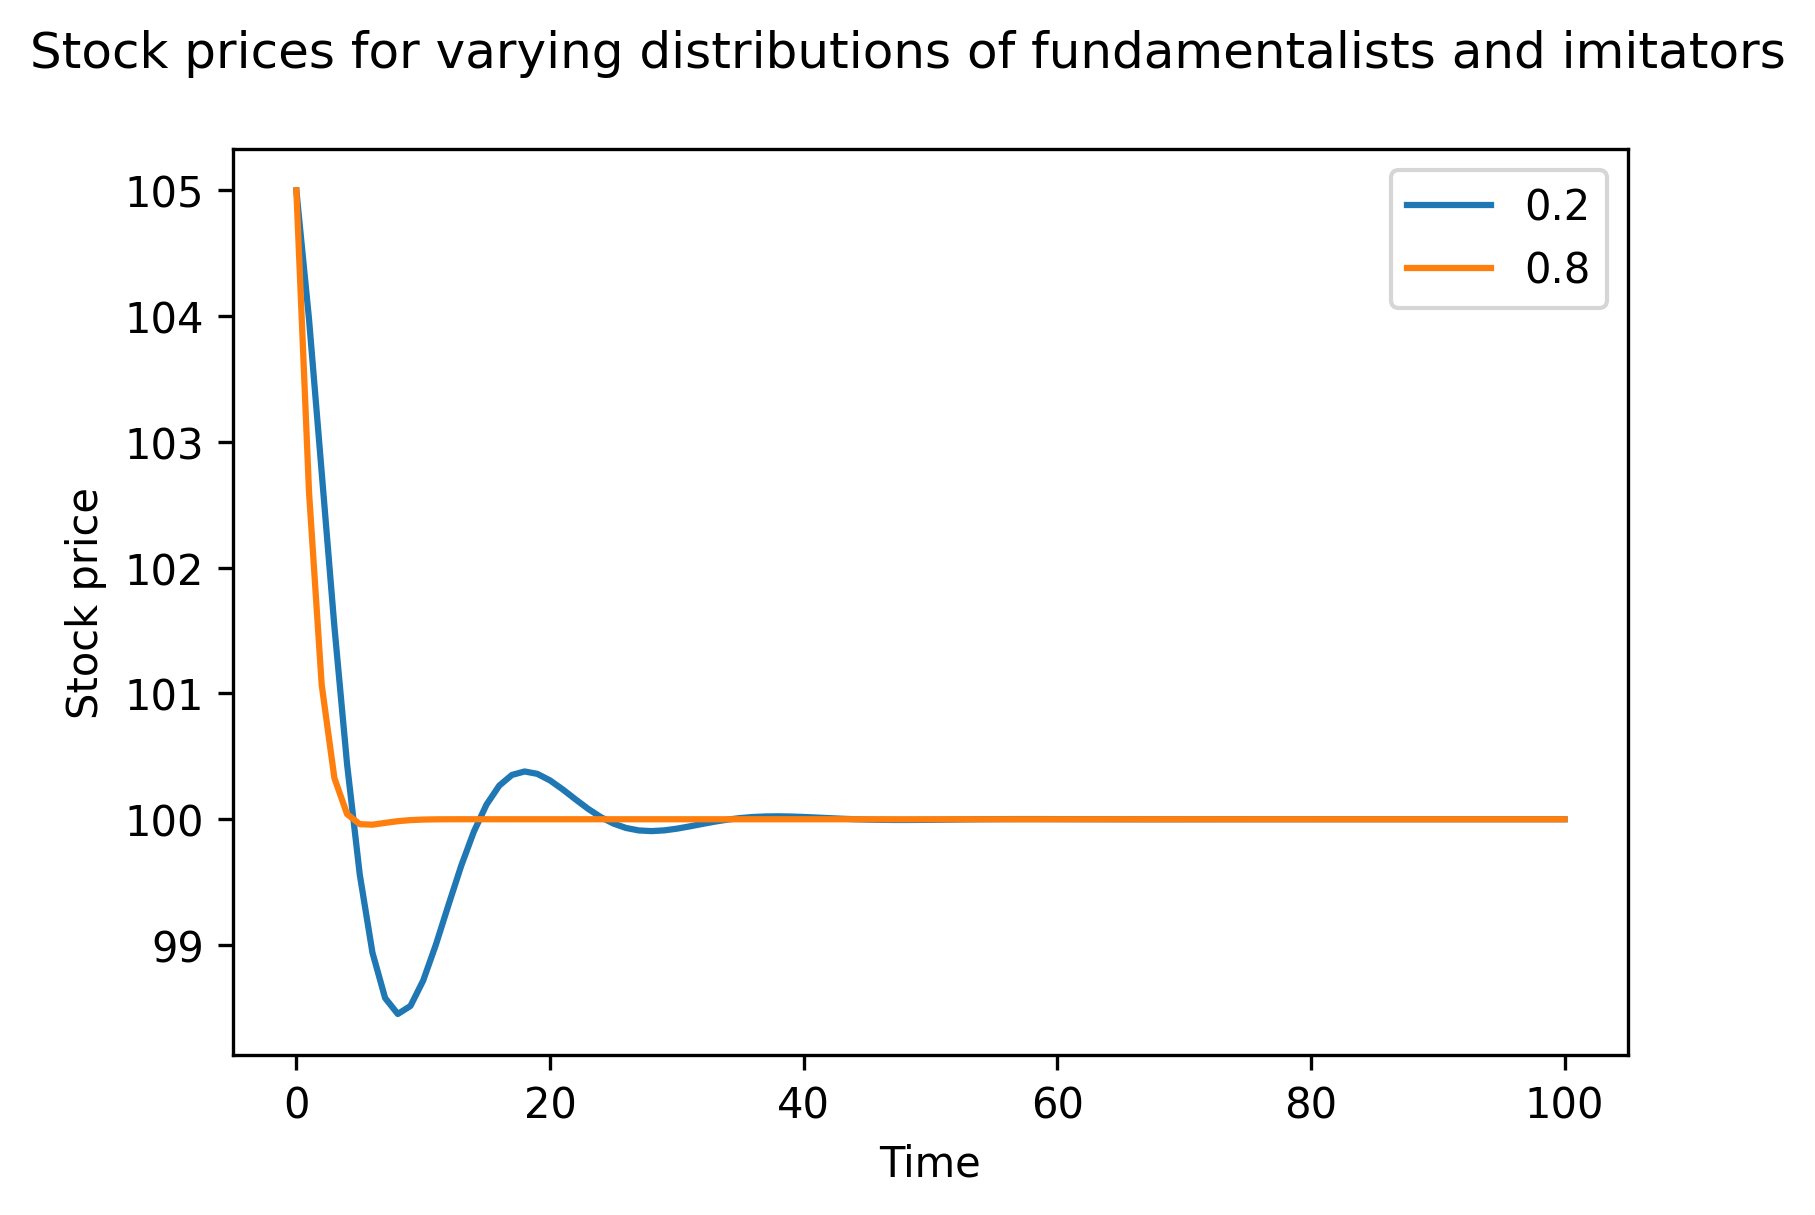

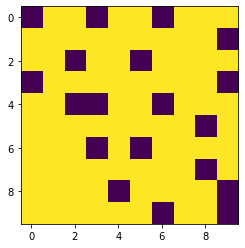

In [14]:
def Level_1_simulation(trader_grid, initial_price, fundamental_value, time, L, sensitivity_contant):
    # initialize price list for market
    price_list = [initial_price]
    # initialize transaction quantities. Note that this implies at t=0 we initialize with imitators not trading and fundamentalists changing to the updated price values
    transaction_quantities = Functions.next_state(trader_grid, np.zeros((L,L)), price_list[-1], fundamental_value, L)
    transactions = [transaction_quantities]
    for t in range(time):
        transactions.append(Functions.next_state(trader_grid, transactions[-1], price_list[-1], fundamental_value, L))
        trans_quantity = Functions.calculation_transaction_quantity(transactions[-1], L)
        price_list.append(Functions.price_function(price_list[-1],sensitivity_contant,L, trans_quantity))
    return np.array(transactions), np.array(price_list)


# Verification plots for Level 1 model
fundamentalists_probabilities = [0.2, 0.8]
L = 10
fundamental_value = 100
initial_price = 105
time = 100
constant = 0.5

plt.figure(dpi = 300)
for p in fundamentalists_probabilities:
    trader_grid = Functions.grid_stock_market(L, p)
    prices = Level_1_simulation(trader_grid, initial_price, fundamental_value, time, L, constant)
    plt.plot(np.arange(time + 1), prices[1], label = p)
plt.suptitle('Stock prices for varying distributions of fundamentalists and imitators')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()
plt.close()
    

trader_grid_presentation = Functions.grid_stock_market(L, 0.2)
# Plot trader type distribution
im = plt.imshow(trader_grid_presentation)
plt.show()

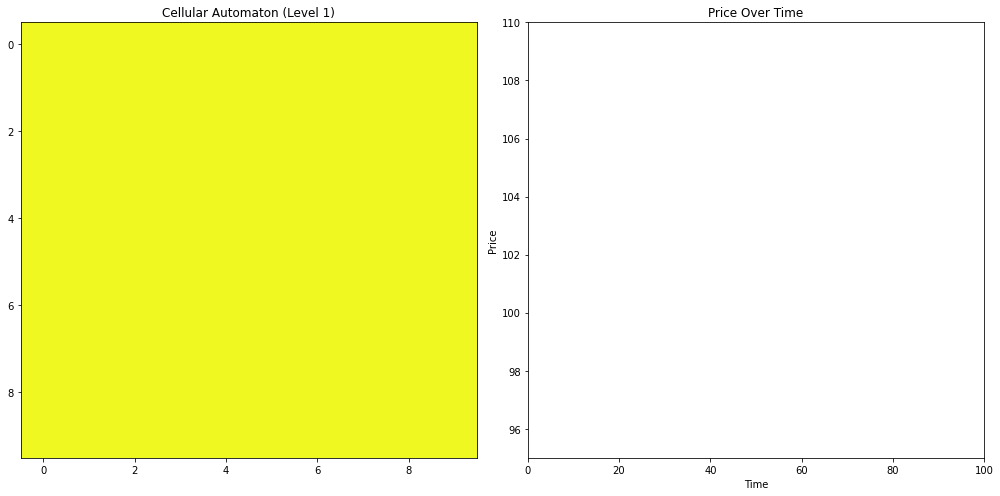

In [11]:
def Level_1_simulation(trader_grid, initial_price, fundamental_value, time, L, sensitivity_constant):
    price_list = [initial_price]
    transaction_quantities = next_state(trader_grid, np.zeros((L, L)), price_list[-1], fundamental_value, L)
    transactions = [transaction_quantities]
    for t in range(time):
        transactions.append(next_state(trader_grid, transactions[-1], price_list[-1], fundamental_value, L))
        trans_quantity = calculation_transaction_quantity(transactions[-1], L)
        price_list.append(price_function(price_list[-1], sensitivity_constant, L, trans_quantity))
    return np.array(transactions), np.array(price_list)

# Set the parameters for the simulation
L = 10
fundamental_value = 100
initial_price = 105
time = 100
constant = 0.8
trader_grid = grid_stock_market(L, 0.2)

# Set the minimum and maximum price limits for the plot
price_min = initial_price - 10
price_max = initial_price + 5

# Create a figure for animation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# CA subplot
ca_axes = axes[0]
ca_axes.set_title('Cellular Automaton (Level 1)')
ca_im = ca_axes.imshow(trader_grid, animated=True, cmap='plasma_r', interpolation='none', aspect='auto')

# Price subplot
price_axes = axes[1]
price_axes.set_title('Price Over Time')
price_axes.set_xlabel('Time')
price_axes.set_ylabel('Price')
price_line, = price_axes.plot([], [], lw=2)
price_axes.set_xlim(0, time)
price_axes.set_ylim(price_min, price_max)

# Animation function
def animate(i):
    # Update the CA image
    ca_im.set_array(Level_1_simulation(trader_grid, initial_price, fundamental_value, i+1, L, constant)[0][-1])
    # Update the price line
    price_line.set_data(np.arange(i+1), Level_1_simulation(trader_grid, initial_price, fundamental_value, i+1, L, constant)[1][:i+1])
    return [ca_im, price_line]

# Create the animation
ani = FuncAnimation(fig, animate, frames=time, interval=250, blit=True)

# Show the animation
plt.tight_layout()
plt.show()

# Save the animation
ani.save('cellular_automaton_level_1.mp4', writer='ffmpeg')

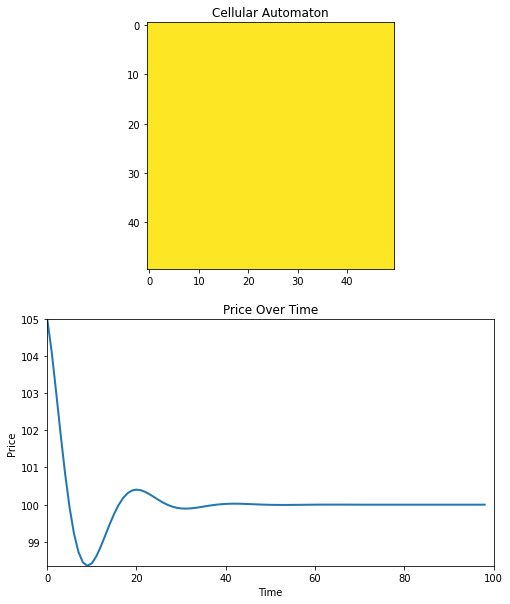

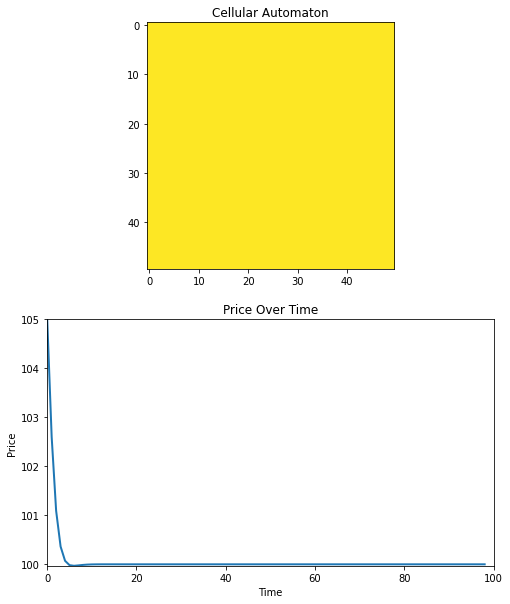

In [22]:
def animate_CA_and_price(fundamentalist_probability, L, fundamental_value, initial_price, time, constant):
    # Initialize the grid and prices
    trader_grid = Functions.grid_stock_market(L, fundamentalist_probability)
    transactions, price_list = Level_1_simulation(trader_grid, initial_price, fundamental_value, time, L, constant)
    
    # Set up the figure and axes
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

    # Initialize the CA plot
    ca_im = ax1.imshow(transactions[0], animated=True, cmap='viridis')
    ax1.set_title('Cellular Automaton')
    
    # Initialize the price plot
    price_line, = ax2.plot([], [], lw=2)
    ax2.set_xlim(0, time)
    ax2.set_ylim(min(price_list), max(price_list))
    ax2.set_title('Price Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')
    
    # Animation update function
    def update(frame):
        ca_im.set_array(transactions[frame])
        price_line.set_data(range(frame), price_list[:frame])
        return ca_im, price_line
    
    # Create and return the animation
    ani = FuncAnimation(fig, update, frames=time, blit=True, interval=50)
    return ani

# Parameters
L = 50
fundamental_value = 100
initial_price = 105
time = 100
constant = 0.5

# Create animations for different probabilities
ani_0_2 = animate_CA_and_price(0.2, L, fundamental_value, initial_price, time, constant)
ani_0_8 = animate_CA_and_price(0.8, L, fundamental_value, initial_price, time, constant)


# To save the animations as a .mp4 file, uncomment:
ani_0_2.save('level_1_cellular_automaton_0_2.mp4', writer='ffmpeg')
ani_0_8.save('level_1_cellular_automaton_0_8.mp4', writer='ffmpeg')